In [1]:
#loading libraries
import platform; 
import sys;
import itertools
from collections import Counter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage import measure, morphology
%matplotlib inline
#loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sl
import matplotlib
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from skimage import measure, morphology


from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.metrics import geometric_mean_score 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold as SKF

import xgboost as xgb
import lightgbm as lgb


from numpy.random import seed
seed(1)

#fix random seed for reproducibility
RANDOM_STATE_VALUE = 1234

print("Python", sys.version)
print("NumPy", np.__version__)
print("SciPy", scipy.__version__)
print("Scikit-Learn", sl.__version__)
print("Matplotlib",matplotlib.__version__)

Python 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609]
NumPy 1.16.4
SciPy 1.3.0
Scikit-Learn 0.20.3
Matplotlib 2.0.0


In [71]:
#util Functions

#plot values generated by SMOTE
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
        
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def plot_2d_space_multiple(X,y,label,ax):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        ax.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    ax.set_title(label)    
    ax.legend(loc='upper right')
    
def do_sampling_tomelinks(train_X,target_Y,ratio):
    tl = TomekLinks(return_indices=True, ratio=ratio)
    X_tl, y_tl, id_tl = tl.fit_sample(train_X, target_Y)
    return X_tl,y_tl,id_tl

def convert_to_encoding(target_y):
    data_encoder = LabelEncoder()
    data_encoder.fit(target_y)
    encoded_y = data_encoder.transform(target_y)
    return encoded_y

def do_sampling_smote(train_X,target_Y,sampling_strategy = 'not minority',smoteenn=True):
    if smoteenn:
        smot_sampler = SMOTEENN(random_state=RANDOM_STATE_VALUE)
        X_res, Y_res = smot_sampler.fit_resample(train_X, convert_to_encoding(target_Y))
    else:
        #no_value=True
        smot_sampler= SMOTE(random_state=RANDOM_STATE_VALUE,ratio='minority')
        #smot_sampler= BorderlineSMOTE(sampling_strategy=sampling_strategy,random_state=RANDOM_STATE_VALUE)
        #smot_sampler = RandomOverSampler(random_state=RANDOM_STATE_VALUE)
        X_res, Y_res = smot_sampler.fit_resample(train_X, convert_to_encoding(target_Y))
    return X_res,Y_res
        

    
def set_ggplot_style():
    plt.style.use('ggplot')
    
def list_of_styles():
    print(plt.style.available)

    
def view_tabular_feature_importances():
    pass

def set_plot_size(width,height):
    plt.rcParams['figure.figsize'] = [width,height]
    
def do_lgb_on_sampled_data(train_X,train_Y,regression=True):
    if regression:
        gbm = lgb.LGBMRegressor()
    else:
        #gbm = lgb.LGBMClassifier(class_weight='balanced')
        #gbm = lgb.LGBMClassifier(scale_pos_weight=1.5)
        gbm = lgb.LGBMClassifier()
    return gbm.fit(train_X, train_Y)

def do_xgb_on_sampled_data(train_X,train_Y,regression=True):
    if regression :
        print("TO DO")
    else:
        xgb_tuned = xgb.XGBClassifier(max_depth=20, n_estimators=200,min_child_weight= 1, learning_rate=0.2,subsample=0.6,
colsample_bytree=0.8,gamma=1,eval_metric='logloss',scale_pos_weight=1.8)
    return xgb_tuned.fit(train_X, train_Y)

def do_random_forest():
    rf_grid_searched_dose = RandomForestClassifier(bootstrap= True,criterion='entropy',max_depth=20,max_features='auto',min_samples_leaf=5,min_samples_split=8,n_estimators=300,random_state=RANDOM_STATE_VALUE)
    rf_vanila_dose = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE_VALUE, n_jobs=-1)
    return rf_vanila_dose

def do_catboost_on_sampled_data(train_X,train_Y,regression=True):
    if regression:
        print("TO DO ")
    else :
        #model_cat = CatBoostClassifier(eval_metric='BalancedAccuracy',use_best_model=True,random_seed=1234)
        model_cat = CatBoostClassifier(eval_metric='BalancedAccuracy',random_seed=1234)
    return model_cat.fit(train_X, train_Y)   
        
def create_confusion_matrix(predictions,target_y):
    encoded_y = convert_to_encoding(target_y) 
    cm = confusion_matrix(encoded_y, predictions)
    return cm,encoded_y
    
def predict_and_create_cm(model,target_x,target_y):
    encoded_y = convert_to_encoding(target_y) 
    predictions = model.predict(target_x)
    cm = confusion_matrix(encoded_y, predictions)
    return cm,predictions,encoded_y

def predict_proba_model(model,target_X):
    predictions_probability = model.predict_proba(target_X)
    return predictions_probability

#calculcate sensitivity and specificity
def calculate_custom_sensitivity(cm):
    tp = cm[1,1]
    tn = cm[0,0]
    fp= cm[0,1]
    fn=cm[1,0]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = tp/(tp+fn)
    # Specificity or true negative rate
    TNR = tn/(tn+fp)
    return TPR,TNR

#calculate 
def plot_confusion_matrix_with_report(cm, classes,ax,bc,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('')
    
    #calculate sensitivity and specificity
    sensitivity,specificity= calculate_custom_sensitivity(cm)
 
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label\n bac={:0.2f};sen={:0.2f}:spe={:0.2f}'.format(bc,round(sensitivity,2),round(specificity,2))) 
    ax.grid(False)



def apply_heuristics_on_generate_data(generated_data_x,generated_data_y,columns_list,train_dummy_X,test_dummy_X,target_train,target_test):
    data_frame_generated = pd.DataFrame(generated_data_x,columns=columns_list)
    data_frame_generated['36months'] = generated_data_y
    
    train_dummy_X['36months'] = target_train
    test_dummy_X['36months'] = target_test
    
    merged_dataframe_test = pd.concat([data_frame_generated, test_dummy_X]) 
    merged_dataframe_test.drop_duplicates(keep=False, inplace=True)
  
    
    merged_dataframe_train = pd.concat([train_dummy_X, merged_dataframe_test]) 
    
    return data_frame_generated,merged_dataframe_test,merged_dataframe_train
 
def get_single_count_from_data_frame (df,variable_name):
    no_,yes_ = df[variable_name].value_counts()
    return no_,yes_

def apply_pseudo_labeling(model,target_X,proba_score,train_X,train_Y):
    predictions_in_probability = predict_proba_model(model,target_X)
    predictions_in_probability_modified = (predictions_in_probability [:,1] >= proba_score).astype('int')
    prediction_dataframe = pd.DataFrame(predictions_in_probability_modified,columns=['36months'])
    augmented_test = target_X.copy(deep=True)
    augmented_test['36months'] = predictions_in_probability_modified
    
    
    augmented_test_label= augmented_test['36months']
    augmented_set_labels = augmented_test.pop('36months')
    new_train_X = np.vstack((train_X, augmented_test.values))
    new_train_Y = np.concatenate((train_Y, augmented_test_label.values), axis=0)
    
    return prediction_dataframe,augmented_test,new_train_X,new_train_Y

def create_merged_data_frame(model,target_X,proba_score,generated_data_x,generated_data_y,columns_list,is_xgb):
    if is_xgb:
        test_X_matrix = target_X.as_matrix()
        predictions_in_probability = predict_proba_model(model,test_X_matrix)
    else :
        predictions_in_probability = predict_proba_model(model,target_X)
        
    predictions_in_probability_modified = (predictions_in_probability [:,1] >= proba_score).astype('int')
    prediction_dataframe = pd.DataFrame(predictions_in_probability_modified,columns=['36months'])
    augmented_test = target_X.copy(deep=True)
    augmented_test['36months'] = predictions_in_probability_modified
    
    data_frame_generated = pd.DataFrame(generated_data_x,columns=columns_list)
    data_frame_generated['36months'] = generated_data_y
    
    merged_dataframe_train = pd.concat([data_frame_generated, augmented_test])
    
    return merged_dataframe_train    
    
    

def pop_labels(dataframe,label_name):
    dataframe_label = dataframe[label_name]
    dataframe.pop(label_name)
    return dataframe,dataframe_label

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


def merge_dataframe_only(list_of_dfs):
    merged =pd.concat([merged_df_rf,merged_df_xgb,merged_df_lgb,merged_df_cat]) 
    merged.drop_duplicates(keep='first', inplace=True)
    merged = clean_dataset(merged)
    return shuffle(merged)

def find_best_cut_off(true_Y,predicted_y):
    fpr, tpr, thresholds = roc_curve(true_Y,predicted_y[:,1],pos_label=1)
    optimal_idx=np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def draw_roc_curve(Y,probs,title):
    # Perforamnce of the model
    fpr, tpr, thresholds = roc_curve(Y,probs,pos_label=1)
    #print('tpr: ', tpr)
    roc_score = roc_auc_score (Y,probs)
    AUC  = auc(fpr, tpr)
    print ('The AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for %s' %title)
    plt.legend(loc="lower right")
    plt.show()

def prepare_data_set_cox_analysis_and_classification(data_main):
    train_data_temp = data_main[data_main.cohort== 1]
    test_data_temp= data_main[data_main.cohort== 2]
    
    print('Procesing Train Data for cox analysis and classification :' ,len(train_data_temp))
    print('Procesing Test Data: for cox analysis and classification :' ,len(test_data_temp))

    train_data_temp = shuffle(train_data_temp)
    test_data_temp = shuffle(test_data_temp)

    test_data_temp['36months']= test_data_temp['36months'].astype('bool')

    train_X_temp = train_data_temp.iloc[:,0:90].astype(float)
    train_temp_y = train_data_temp.iloc[:,2].astype(float)
    
    del train_X_temp['36months']
    del train_X_temp['cohort']
    del train_X_temp['bleeded']

    test_X_temp = test_data_temp.iloc[:,0:90].astype(float)
    test_temp_y = test_data_temp.iloc[:,[0,2]]
    
    del test_X_temp['36months']
    del test_X_temp['months']
    del test_X_temp['cohort']
    del test_X_temp['bleeded']
    
    return train_X_temp,train_temp_y,test_X_temp,test_temp_y


def create_data_set_for_cox_and_classification_after_smote (X_res_train_temp,Y_res_train_temp,columns_list):
    data_frame_generated = pd.DataFrame(X_res_train_temp,columns=columns_list)
    data_frame_generated['36months'] = Y_res_train_temp
    data_frame_cox_target = data_frame_generated.iloc[:,[0,87]]
    #del data_frame_generated['months']
    return data_frame_generated,data_frame_cox_target

def plot_feature_importances(model,feature_names,number_of_features,title):
    plt.rcParams['figure.figsize'] = [10,8]
    feat_importances = pd.Series(model.feature_importances_, index=feature_names.columns)
    feat_importances.nlargest(20).plot(kind='barh',color=colors)
    plt.title('First {} Important Features for {}'.format(number_of_features, title) , fontsize = 20)
    plt.yticks(fontsize = 10)
    plt.ylabel('Name of the features',fontsize = 20)
    
    
#helper function to generate color palette
import random

def get_random_color(pastel_factor = 0.7):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = []
for i in range(0,30):
    colors.append(generate_new_color(colors,pastel_factor = 0.8))
    
def get_important_features_list (model,columns_list,num_of_features):
    feat_importances = pd.Series(model.feature_importances_, index=columns_list)
    df=feat_importances.nlargest(num_of_features)
    important_features_list = []
    
    for i, v in df.items():
        important_features_list.append(i)
    return important_features_list

def do_tsne(target_X,number_of_components):
    tsne = TSNE(n_components=number_of_components,random_state=RANDOM_STATE_VALUE)
    #transformed_2d = tsne.fit_transform(target_X)
    return tsne.fit_transform(target_X)

def apply_rf(params,default=False):
    if default:
        rf_clf= RandomForestClassifier(random_state=RANDOM_STATE_VALUE)
    else:
        rf_clf= RandomForestClassifier(**params)
    return rf_clf


def apply_grid_search_rf(target_X,target_Y):
    rfc=RandomForestClassifier(random_state=RANDOM_STATE_VALUE,n_jobs=-1)
    param_grid = { 
    'bootstrap': [True],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [20,30,40,50,60,70,80,90,100],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,150,200,250,300,400,500],
    'criterion' :['gini', 'entropy']
    }

    scorers = {
    #'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score)
    }

    refit_score = 'recall_score'

    kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE_VALUE)    
    rf_grid = GridSearchCV(rfc, param_grid, cv=kfold,scoring=scorers,verbose=1,refit=refit_score,n_jobs=-1)

    rf_grid.fit(target_X, target_Y)
    
    return rf_grid
    

def draw_roc_curve_multiple(Y,probs,title):
    # Perforamnce of the model
    fpr, tpr, thresholds = roc_curve(Y,probs,pos_label=1)
    #print('tpr: ', tpr)
    roc_score = roc_auc_score (Y,probs)
    AUC  = auc(fpr, tpr)
    print ('The AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for %s' %title)
    plt.legend(loc="lower right")
    plt.show()
    
def do_pca(target_X,number_of_components):
    pca = PCA(n_components=number_of_components)
    return pca.fit_transform(target_X)

def create_data_frame_from_sampling_array(generated_data_x,generated_data_y):
    data_frame_generated = pd.DataFrame(generated_data_x)
    data_frame_generated['36months'] = generated_data_y
    
    target_Y = data_frame_generated['36months']
    data_frame_generated.pop('36months')

    return data_frame_generated,target_Y


def create_data_frame_from_sampling_array_for_covariate(generated_data_x,generated_data_y,label):
    data_frame_generated = pd.DataFrame(generated_data_x)
    data_frame_generated[label] = generated_data_y
    return data_frame_generated

def get_important_features_list (model,columns_list,num_of_features):
    feat_importances = pd.Series(model.feature_importances_, index=columns_list)
    df=feat_importances.nlargest(num_of_features)
    important_features_list = []
    
    for i, v in df.items():
        important_features_list.append(i)
    return important_features_list


In [3]:
#data pre-processing
INPUT_FOLDER = 'rennes_prostate_cancer/input_data/'
OUTPUT_FOLDER = 'rennes_prostate_cancer/output_results/'
data_main = pd.read_excel(INPUT_FOLDER+'data.xls', index_col=None)

conditions = [
    (data_main['months'] < 36) & (data_main['bleeded']== 1.00)]
choices = [1.00]

data_main['36months'] = np.select(conditions, choices, default=0.00)

#data_main.to_csv(OUTPUT_FOLDER+'prepared_dataset.csv', encoding='utf-8', index=False) un comment if you want something else

train_data = data_main[data_main.cohort== 1]
test_data= data_main[data_main.cohort== 2]
print('Train Data: ' ,len(train_data))
print('Test Data: ' ,len(test_data))

from sklearn.utils import shuffle
train_data = shuffle(train_data)
test_data = shuffle(test_data)

#preparing training set
train_X = train_data.iloc[:,0:90].astype(float)
#train_temp_y = train_X.iloc[:,2].astype(float)
#target_train_X = train_data['36months']
#print('Labels of Trained data: ',len(train_temp_y))
#del train_X['36months']
del train_X['cohort']
del train_X['months']
del train_X['bleeded']
train_X.head()
#train_X.to_csv(OUTPUT_FOLDER+'prepared_dataset_test.csv', encoding='utf-8', index=False) #un comment if you want something else

#preparing testing set
test_X = test_data.iloc[:,0:90].astype(float)
test_temp_y = test_X.iloc[:,2].astype(float)
#target_test_X = test_data['36months']
#print('Labels of Test data: ' , len(test_temp_y))
#del test_X['36months']
del test_X['cohort']
del test_X['months']
del test_X['bleeded']
test_X.head()

target_train = train_X['36months']
target_test = test_X['36months']

train_set_labels = train_X.pop('36months')
test_set_labels = test_X.pop('36months')

Train Data:  337
Test Data:  254


ROC-AUC for train and test distributions: 97.490% (2.838%)

Resampled dataset for training shape Counter({0: 337, 1: 337})
Resampled dataset for testing shape Counter({0: 297, 1: 283})
(674, 87)


,age,antticoagulant_i,hormono,dose_total in the prostate,"imrt_only (0=no, 1=yes)",imr_plus_igrt,V0,V1= Volume of the rectum in % receiving a minimum of 1 Gy,V2,V3,...,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79
0,65.819178,0.0,1.0,78.0,1.0,0.0,100.0,100.0,100.0,99.6853,...,14.9523,13.5878,12.1970,10.66100,7.23201,0.989538,0.025650,0.0,0.0,0.0
1,61.509589,0.0,1.0,80.0,1.0,0.0,100.0,100.0,100.0,100.0000,...,13.2546,11.8597,10.2528,8.54631,5.85300,1.245910,0.022334,0.0,0.0,0.0


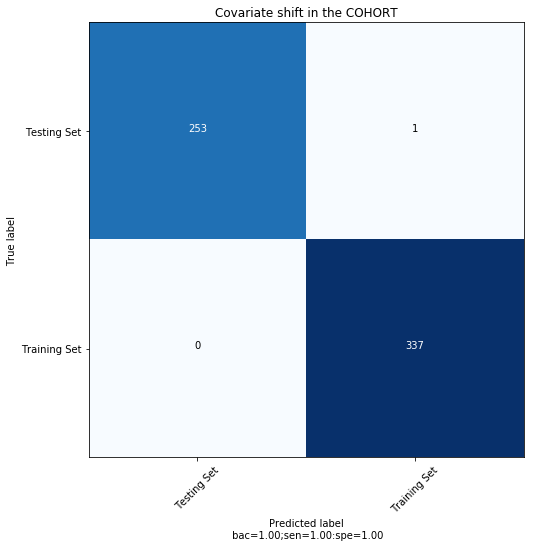

In [4]:
#prorepare data for covariate shift and visualize it 
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

covariate_train_X = train_X.copy()
covariate_test_X = test_X.copy()

covariate_train_X['is_train'] = 1
covariate_test_X['is_train'] = 0 


covariate_combine = pd.concat([covariate_train_X, covariate_test_X], axis=0, ignore_index=True)
covariate_combine_target=covariate_combine['is_train']


Y = covariate_combine['is_train'].values #labels
X = covariate_combine.drop('is_train', axis=1).values #covariates or our independent variables


covariate_combine_lbl = covariate_combine.pop('is_train')
covariate_combine.head(2)

clf_co = RandomForestClassifier(n_jobs=-1,random_state=RANDOM_STATE_VALUE)

refit_score = 'roc_auc'
skfold = SKF(n_splits=20, shuffle=True, random_state=RANDOM_STATE_VALUE)
roc_score_cs = cross_val_score(clf_co, X, Y, scoring=refit_score, cv = skfold)

print("ROC-AUC for train and test distributions: %.3f%% (%.3f%%)" % (roc_score_cs.mean()*100.0, roc_score_cs.std()*100.0))

#print confusion matrix for the distribution
clf_co.fit(X,Y)
predictions = clf_co.predict(X)
bac = balanced_accuracy_score(Y, predictions)
cm = confusion_matrix(Y, predictions.round())

#visualize confustion matrix
fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Testing Set', 'Training Set'],ax=ax,bc=bac.round(),
                      title='Covariate shift in the COHORT')



#applying SMOTE and SMOTEENN
X_res_cov_smote,Y_res_cov_smote = do_sampling_smote(covariate_combine,covariate_combine_target,sampling_strategy = 'not minority',smoteenn=False)
print('Resampled dataset for training shape %s' % Counter(Y_res_cov_smote))

X_res_cov_smoteenn,Y_res_cov_smoteenn = do_sampling_smote(covariate_combine,covariate_combine_target,sampling_strategy = 'not minority',smoteenn=True)
print('Resampled dataset for testing shape %s' % Counter(Y_res_cov_smoteenn))


cov_df_smote = pd.DataFrame(X_res_cov_smote,columns=covariate_combine.columns)
cov_df_smote['is_train'] = Y_res_cov_smote
print(cov_df_smote.shape)

cov_df_smote_train_data = cov_df_smote[cov_df_smote.is_train== 1]
cov_df_smote_test_data = cov_df_smote[cov_df_smote.is_train== 0]

smote_lbl_cov_tr = cov_df_smote_train_data.pop('is_train')
smote_lbl_cov_ts = cov_df_smote_test_data.pop('is_train')

cov_df_smote_train_data.head(2)


In [5]:
#prepare dataset for final training

train_prep_X,train_prep_y,test_cox_X,test_cox_y = prepare_data_set_cox_analysis_and_classification(data_main)
train_prep_X.head(2)
#X_res_train_temp,Y_res_train_temp,idx = do_sampling_tomelinks(train_prep_X,train_prep_y,'majority')
X_res_train_temp,Y_res_train_temp = do_sampling_smote(train_prep_X,train_prep_y,sampling_strategy = 'not minority',smoteenn=True)
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_temp))

print('Preparing Training set after applying SMOTEENN')
data_frame_train_X,data_frame_cox_target = create_data_set_for_cox_and_classification_after_smote(X_res_train_temp,Y_res_train_temp,train_prep_X.columns)
data_frame_target_train = data_frame_train_X['36months']
data_frame_train_set_labels = data_frame_train_X.pop('36months')

del data_frame_train_X['months']

data_frame_train_X.head(2)

Procesing Train Data for cox analysis and classification : 337
Procesing Test Data: for cox analysis and classification : 254
Resampled dataset shape for training set:  Counter({1: 308, 0: 299})
Preparing Training set after applying SMOTEENN


,age,antticoagulant_i,hormono,dose_total in the prostate,"imrt_only (0=no, 1=yes)",imr_plus_igrt,V0,V1= Volume of the rectum in % receiving a minimum of 1 Gy,V2,V3,...,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79
0,71.293151,0.0,1.0,80.0,1.0,0.0,100.0,100.0,98.6192,95.0677,...,13.3687,12.0047,10.5074,8.66351,5.94861,2.14517,0.346690,0.004209,0.0,0.0
1,74.767123,0.0,0.0,80.0,1.0,0.0,100.0,100.0,99.9554,98.5912,...,14.2217,12.8279,11.1897,9.18956,6.65126,2.68426,0.125949,0.000000,0.0,0.0


In [6]:
#calculate density estimation ratio in the training set
from densratio import densratio
np.random.seed(1)
alpha = 0
densratio_obj = densratio(cov_df_smote_train_data.values, cov_df_smote_test_data.values, alpha=alpha, sigma_range=[0.1, 0.3, 0.5, 0.7, 1], lambda_range=[0.01, 0.02, 0.03, 0.04, 0.05])
#densratio_obj = densratio(covariate_train_X.values, covariate_test_X.values, alpha=alpha, sigma_range=[0.1, 0.3, 0.5, 0.7, 1], lambda_range=[0.01, 0.02, 0.03, 0.04, 0.05])
density_ratio = densratio_obj.compute_density_ratio(data_frame_train_X)

RuLSIF starting...
Searching for the optimal sigma and lambda...
sigma = 0.10000, lambda = 0.01000, score = 0.00000
sigma = 0.10000, lambda = 0.02000, score = 0.00000
sigma = 0.10000, lambda = 0.03000, score = 0.00000
sigma = 0.10000, lambda = 0.04000, score = 0.00000
sigma = 0.10000, lambda = 0.05000, score = 0.00000
sigma = 0.30000, lambda = 0.01000, score = -0.00000
sigma = 0.30000, lambda = 0.02000, score = -0.00000
sigma = 0.30000, lambda = 0.03000, score = -0.00000
sigma = 0.30000, lambda = 0.04000, score = -0.00000
sigma = 0.30000, lambda = 0.05000, score = -0.00000
sigma = 0.50000, lambda = 0.01000, score = -0.00000
sigma = 0.50000, lambda = 0.02000, score = -0.00000
sigma = 0.50000, lambda = 0.03000, score = -0.00000
sigma = 0.50000, lambda = 0.04000, score = -0.00000
sigma = 0.50000, lambda = 0.05000, score = -0.00000
sigma = 0.70000, lambda = 0.01000, score = -0.00000
sigma = 0.70000, lambda = 0.02000, score = -0.00000
sigma = 0.70000, lambda = 0.03000, score = -0.00000
sigm

In [7]:
data_frame_train_X.shape

(607, 86)

In [24]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Input

# baseline model - results using model_1

def create_model(X_train):
    
    input_dim = X_train.shape[1] #num of predictor variables
    encoding_dim = 128
    hidden_dim = int(encoding_dim / 2)
    learning_rate = 1e-3
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(hidden_dim, activation="relu")(encoder)
    decoder = Dense(encoding_dim, activation="relu")(decoder)
    decoder = Dense(input_dim, activation="linear")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    autoencoder.compile(optimizer='adam',loss='binary_crossentropy', metrics=[keras.metrics.Recall(name='recall'),keras.metrics.Precision(name='precision')])
    autoencoder.summary()
    return autoencoder,encoder

#convert label to the encoding   
encoded_Y = convert_to_encoding(data_frame_target_train)
autoencoder,encoder = create_model(data_frame_train_X)
ae_history = autoencoder.fit(data_frame_train_X,data_frame_train_X,epochs=15, batch_size=32,verbose=1,sample_weight=density_ratio,validation_data=(test_X,test_X))



Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 86)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 128)               11136     
_________________________________________________________________
dense_61 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_63 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_64 (Dense)             (None, 86)                11094     
Total params: 42,966
Trainable params: 42,966
Non-trainable params: 0
______________________________________________________

In [27]:
#define a encoder
encoder = Model(inputs = autoencoder.input, outputs = encoder)


In [48]:
#features selected by encoder
encoded_train = pd.DataFrame(encoder.predict(data_frame_train_X))
encoded_train = encoded_train.add_prefix('feature_')

encoded_test = pd.DataFrame(encoder.predict(test_X))
encoded_test = encoded_test.add_prefix('feature_')

In [42]:
#debugging purpose only
encoded_train['target'] = encoded_Y
no,yes= get_single_count_from_data_frame (encoded_train,'target')
print('Training set: Negative Outcome>> %d and positive outcome: %d' %(no,yes))

encoded_test_Y = convert_to_encoding(target_test) 
encoded_test['target'] = encoded_test_Y
no,yes= get_single_count_from_data_frame (encoded_test,'target')
print('Testing set: Negative Outcome>> %d and positive outcome: %d' %(no,yes))

Training set: Negative Outcome>> 308 and positive outcome: 299


In [49]:
#Grid Search random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=RANDOM_STATE_VALUE)
param_grid = { 
    'bootstrap': [True],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [20,30,40,50,60,70,80,90,100],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,150,200,250,300,400],
    'criterion' :['gini', 'entropy']
}
#multiple evaluation scoring
scores = ['recall','balanced_accuracy']
#clf = GridSearchCV(rfc, param_grid, cv=5,refit='balanced_accuracy',
                       #scoring=scores,verbose=5)
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE_VALUE)
clf_dose = GridSearchCV(rfc, param_grid, cv=kfold,scoring='balanced_accuracy',verbose=5,n_jobs=-1)
clf_dose.fit(encoded_train, encoded_Y)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [3, 4, 5], 'n_estimators': [100, 150, 200, 250, 300, 400], 'bootstrap': [True], 'min_samples_split': [8, 10, 12], 'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=5)

In [50]:
print('Best Params: ' , clf_dose.best_params_)
print('Best Estimators: ' ,clf_dose.best_estimator_)
print('Best Index: ' ,clf_dose.best_index_)
print('Best Results: ' ,clf_dose.cv_results_)

Best Params:  {'max_depth': 30, 'criterion': 'entropy', 'min_samples_leaf': 3, 'n_estimators': 250, 'bootstrap': True, 'min_samples_split': 10, 'max_features': 'auto'}
Best Estimators:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)
Best Index:  1629
Best Results:  {'split3_train_score': array([0.95890434, 0.95890434, 0.95485576, ..., 0.92408483, 0.92408483,
       0.92192502]), 'std_train_score': array([0.00612041, 0.00799103, 0.00611064, ..., 0.00544465, 0.00460518,
       0.00645383]), 'param_max_depth': masked_array(data=[20, 20, 20, ..., 100, 100, 100],
             mask=[False, False, False, ..., False, Fal

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [58]:

#Without Kfold
rf_clf = RandomForestClassifier(bootstrap= True,criterion='entropy',max_depth=30,max_features='auto',min_samples_leaf=3,min_samples_split=10,n_estimators=250,random_state=RANDOM_STATE_VALUE) 

rf_clf.fit(encoded_train,encoded_Y)

cm,predictions,test_Y = predict_and_create_cm(rf_clf,encoded_test,encoded_test_Y)

balanced_accuracy = recall_score(test_Y,predictions, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predictions)
roc_score = roc_auc_score (test_Y,predictions)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
print(cm)
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))


print("AFTER APPLYING THRESHOLD>>>>>>")
test_Y = convert_to_encoding(target_test) 
probs_rf_grid_searched_dose_thres = predict_proba_model(rf_clf,encoded_test)
threshold = round(find_best_cut_off(test_Y,probs_rf_grid_searched_dose_thres),2)
print('Optimal cut-off value:' , threshold)


predicted_grid_searched_dose_thres = (probs_rf_grid_searched_dose_thres [:,1] >= threshold).astype('int')

cm = confusion_matrix(test_Y, predicted_grid_searched_dose_thres)

balanced_accuracy = recall_score(test_Y,predicted_grid_searched_dose_thres, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predicted_grid_searched_dose_thres)
roc_score = roc_auc_score (test_Y,predicted_grid_searched_dose_thres)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))
print(cm)

Balanced Accuracy for RF:  56.99999999999999
MCC for RF:  0.15061363031208064
ROC :  56.99999999999999
Confusion Matrix: 
[[220  12]
 [ 18   4]]
Sensitivity: 0.18: and Specificity:0.95
AFTER APPLYING THRESHOLD>>>>>>
Optimal cut-off value: 0.31
Balanced Accuracy for RF:  64.0
MCC for RF:  0.17559381317778897
ROC :  64.0
Confusion Matrix: 
Sensitivity: 0.55: and Specificity:0.74
[[171  61]
 [ 10  12]]


Threshold value is:  0.54
Shape after removing duplicates:  (861, 65)
Resampled dataset shape for training set:  Counter({1: 291, 0: 261})
Apply pseudo labeling
Balanced Accuracy for RF:  66.0
MCC for RF:  0.18947164027853736
ROC :  66.0
Confusion Matrix: 
[[167  65]
 [  9  13]]
Sensitivity: 0.59: and Specificity:0.72

AFTER APPLYING THRESHOLD>>>>>>
Optimal cut-off value: 0.71
Balanced Accuracy for RF:  68.0
MCC for RF:  0.2364084149254407
ROC :  68.0
Confusion Matrix: 
Sensitivity: 0.59: and Specificity:0.78
[[180  52]
 [  9  13]]



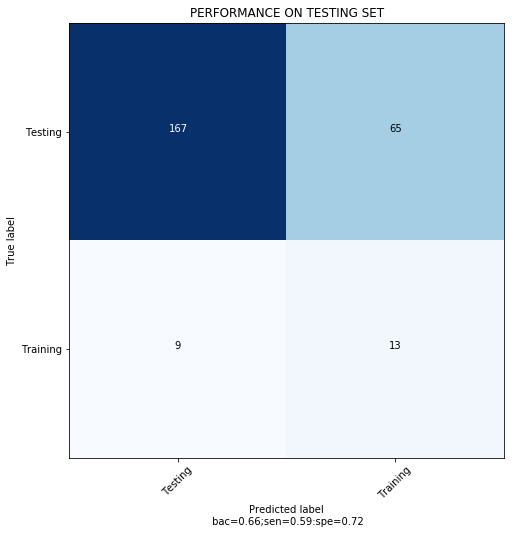

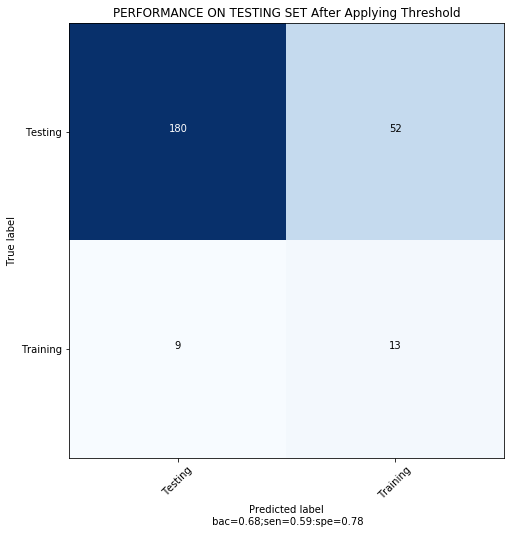

In [75]:
#Apply psuedo labeling
set_threshold=threshold
print('Threshold value is: ',set_threshold)

merged_df_rf= create_merged_data_frame(rf_clf,encoded_test,set_threshold,encoded_train,encoded_Y,encoded_train.columns,False)
merged_df_rf = shuffle(merged_df_rf)
merged_df_rf.drop_duplicates(keep='first', inplace=True)
print('Shape after removing duplicates: ', merged_df_rf.shape) 


augmented_x,augmented_test_y = pop_labels(merged_df_rf,'36months')
X_res_train_augmented,Y_res_train_augmented = do_sampling_smote(augmented_x,augmented_test_y,sampling_strategy = 'not minority',smoteenn=True)
#print(sorted(Counter(y_res).items()))
print('Resampled dataset shape for training set:  %s' % Counter(Y_res_train_augmented))

print('Apply pseudo labeling')

#rf_clf.fit(augmented_x,augmented_test_y)
rf_clf.fit(X_res_train_augmented,Y_res_train_augmented)

cm,predictions,test_Y = predict_and_create_cm(rf_clf,encoded_test,encoded_test_Y)

balanced_accuracy = recall_score(test_Y,predictions, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predictions)
roc_score = roc_auc_score (test_Y,predictions)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
print(cm)
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))

fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Testing', 'Training'],ax=ax,bc=balanced_accuracy,
                      title='PERFORMANCE ON TESTING SET')

print("AFTER APPLYING THRESHOLD>>>>>>")
test_Y = convert_to_encoding(target_test) 
probs_rf_grid_searched_dose_thres = predict_proba_model(rf_clf,encoded_test)
threshold = round(find_best_cut_off(test_Y,probs_rf_grid_searched_dose_thres),2)
print('Optimal cut-off value:' , threshold)


predicted_grid_searched_dose_thres = (probs_rf_grid_searched_dose_thres [:,1] >= threshold).astype('int')

cm = confusion_matrix(test_Y, predicted_grid_searched_dose_thres)

balanced_accuracy = recall_score(test_Y,predicted_grid_searched_dose_thres, average='macro') 
mcc_coef= matthews_corrcoef(test_Y, predicted_grid_searched_dose_thres)
roc_score = roc_auc_score (test_Y,predicted_grid_searched_dose_thres)

print('Balanced Accuracy for RF: ' , round(balanced_accuracy,2)*100)
print('MCC for RF: ' , mcc_coef)
print('ROC : ' , round(roc_score,2)*100)
print('Confusion Matrix: ')
sensititvity,specificity = calculate_custom_sensitivity(cm)
print("Sensitivity: {:0.2f}: and Specificity:{:0.2f}".format(sensititvity,specificity))
print(cm)

fig, ax = plt.subplots(ncols=1,figsize=(8,8))
plot_confusion_matrix_with_report(cm, classes=['Testing', 'Training'],ax=ax,bc=balanced_accuracy,
                      title='PERFORMANCE ON TESTING SET After Applying Threshold')

In [ ]:
#finding best parameter for xgb
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators':[200,400,600,1000],
        'max_depth': [20,50],
        'scale_pos_weight':[1.8,2.50,3.5],
        'eval_metric':['auc'],         
        'learning_rate':[0.001, 0.01,0.02,0.1, 0.2, 0.3]
        }

scorers = {
    'roc_score': make_scorer(roc_auc_score),
    #'recall_score': make_scorer(recall_score),
    #'balanced_accuracy_score': make_scorer(balanced_accuracy_score)
}
#
scores = ['recall','balanced_accuracy']
refit_score = 'roc_score'

kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=RANDOM_STATE_VALUE)

xgb_grid = XGBClassifier()
#grid_xgb = GridSearchCV(estimator=xgb_grid, param_grid=param_grid, scoring=scorers,n_jobs=4, cv=kfold,verbose=1,refit=refit_score)
grid_xgb = GridSearchCV(estimator=xgb_grid, param_grid=param_grid,scoring='balanced_accuracy',n_jobs=-1, cv=kfold,verbose=1)


grid_xgb.fit(encoded_train, encoded_Y)